### imports

In [108]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import string
import math
import time
import cmath
np.set_printoptions(precision=3, suppress=True)


# Q1. Blurry Moments

## a)


In [109]:
def multiply_kernel(kernel,image):
    a,b = np.shape(kernel)
    kernel = kernel.reshape(a*b)
    image = image.reshape(a*b)

    output = np.dot(kernel,image)
    
    kernel = kernel.reshape(a,b)
    image = image.reshape(a,b)
    return output

In [110]:
def gaussKernelGenerator(k , var):
    kernel = np.zeros((k,k))
    kl = math.floor(k/2)
    for i in range(k):
        for j in range(k):
            kernel[i,j] = math.exp(-(pow((i-kl),2) + pow((j-kl),2))/(2*pow(var,2)))
    const = np.sum(kernel)
    kernel = np.divide(kernel,const)
    return kernel

k = 3
var = 1.5
kernel = gaussKernelGenerator(k,var)

In [111]:
def gaussianFilter(image,var,k):
    kernel = gaussKernelGenerator(k,var)
    
    img = image.copy()
    [x,y] = np.shape(img)

    output = np.zeros(np.shape(img))
    
    img = np.pad(img,math.floor(k/2))
    
    for i in range(x):
        for j in range(y):
            output[i,j] = multiply_kernel(kernel,img[i:i+k,j:j+k])
    output = (np.round(output)).astype(int)
    return output

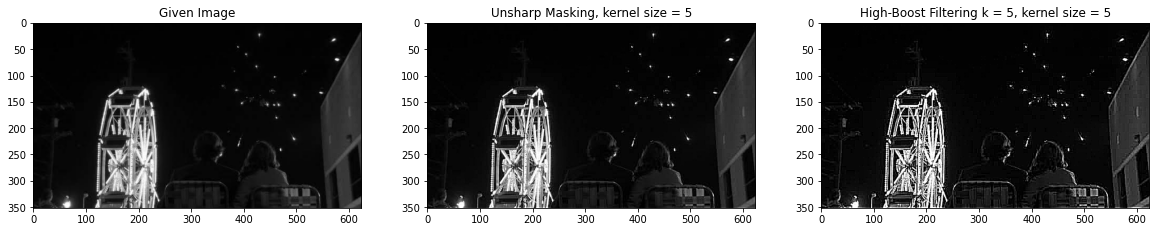

In [112]:
def unsharp_masking(image,size):
    img = image.copy()
    blurr = gaussianFilter(img,5,size)
    mask = np.subtract(img,blurr)
    output = img+mask
    where = np.where(output>255)
    output[where] = 255
    where = np.where(output<0)
    output[where] = 0
    return output

def high_boost(image,k,size):
    img = image.copy()
    blurr = gaussianFilter(img,5,size)
    mask = np.subtract(img,blurr)
    mask = np.multiply(mask,k)
    output = img+mask
    where = np.where(output>255)
    output[where] = 255
    where = np.where(output<0)
    output[where] = 0
    return output

k=5
size = [3,5,9]
image = cv2.imread('../imgs/Jam.jpg',0)


plt.figure(figsize=(20,10))
output = unsharp_masking(image,5)
output2 = high_boost(image,k,5)
plt.subplot(131)
plt.imshow(image,cmap='gray',vmin=0,vmax=255)
plt.title("Given Image")

plt.subplot(132)
plt.imshow(output,cmap='gray',vmin=0,vmax=255)
plt.title("Unsharp Masking, kernel size = 5")

plt.subplot(133)
plt.imshow(output2,cmap='gray',vmin=0,vmax=255)
plt.title("High-Boost Filtering k = 5, kernel size = 5")
plt.show()

## b)

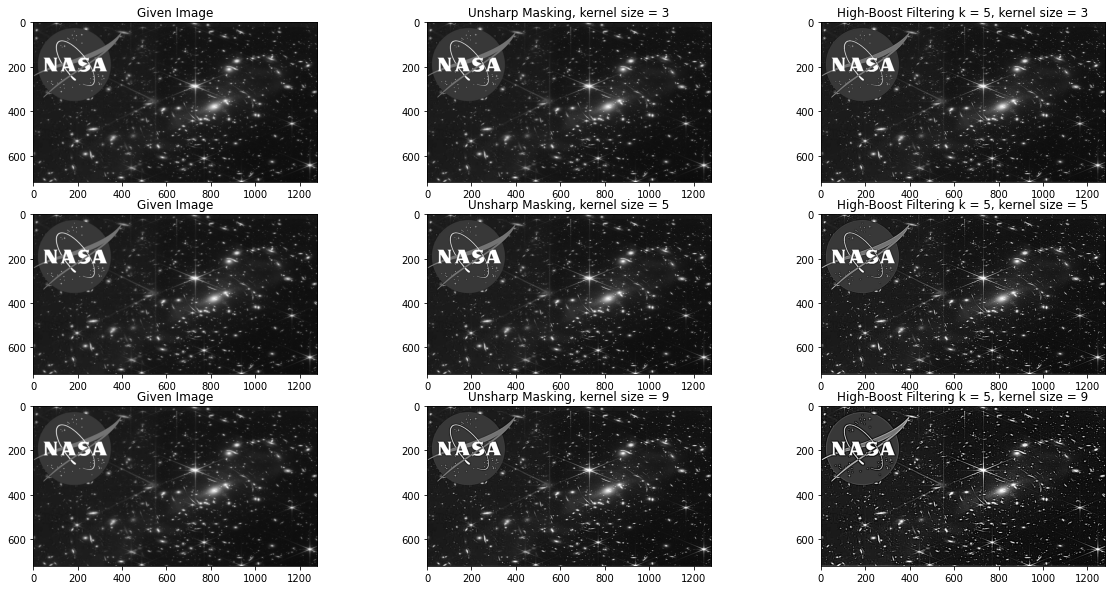

In [113]:
k=5
size = [3,5,9]
image = cv2.imread('../imgs/webb.jpg',0)


plt.figure(figsize=(20,10))
for i in range(3):
    output = unsharp_masking(image,size[i])
    output2 = high_boost(image,k,size[i])
    plt.subplot(3,3,3*i+1)
    plt.imshow(image,cmap='gray',vmin=0,vmax=255)
    plt.title("Given Image")

    plt.subplot(3,3,3*i+2)
    plt.imshow(output,cmap='gray',vmin=0,vmax=255)
    plt.title("Unsharp Masking, kernel size = "+str(size[i]))

    plt.subplot(3,3,3*i+3)
    plt.imshow(output2,cmap='gray',vmin=0,vmax=255)
    plt.title("High-Boost Filtering k = 5, kernel size = "+str(size[i]))

plt.show()

As we increase the kernel size the edge become more sharp because the origional image is getting more blur hence when we find the mask it contains more edges. It is same for high boost and unsharp masking  

# Q2. Intentionally Blurry Moments

In [114]:
def generate_weights(img,d,r):
    simg = img.copy()
    x,y = np.shape(simg)
    w = np.zeros(np.shape(simg))
    xt = int(np.floor(x/2))
    k=-0
    for (i,j),val in np.ndenumerate(w):
        # print(i,end=' ')
        # print(j,end=' ')
        # print(val,end=' ')
        k = -((pow((i-xt)/d,2)+pow((j-xt)/d,2))/(2))-(pow(abs(int(img[xt,xt]) - int(img[i,j]))/r,2)/(2))
        # print(k)
        w[i,j] =  math.exp(k)
    return w
    


In [115]:
def bilateral_filtering(image,d,r,k):
    img = image.copy()
    kl = int(np.floor(k/2))
    output = np.zeros(np.shape(img))
    img = np.pad(img,kl)
    for (i,j),val in np.ndenumerate(output):
        w =  generate_weights(img[i:i+k,j:j+k],d,r)
        # print(w)
        
        output[i,j] = multiply_kernel(w,img[i:i+k,j:j+k])/np.sum(w)
    
    output = np.round(output)
    
    return output



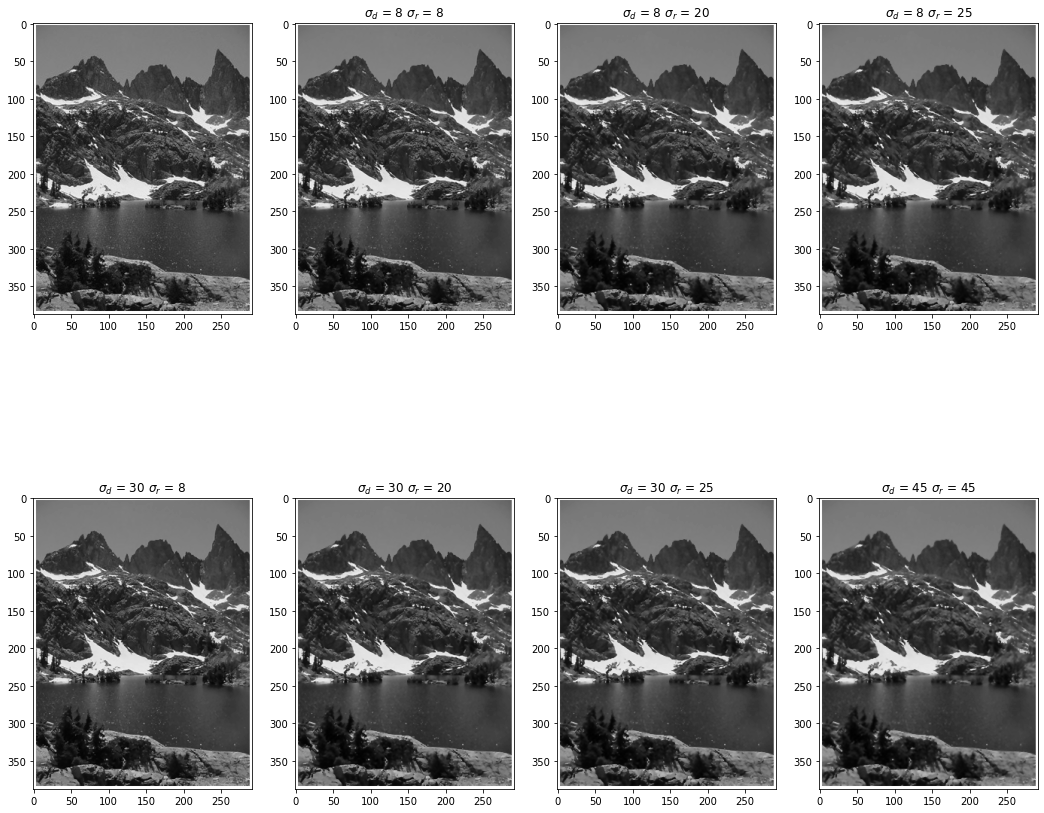

In [116]:
image = cv2.imread('../imgs/lakeside.jpg',0)

sigs = [(8,8),(8,20),(8,25),(30,8),(30,20),(30,25),(45,45)]
plt.figure(figsize=(18,16))
i=2
plt.subplot(241)
plt.imshow(image,cmap='gray')

for d,r in sigs:
    output = bilateral_filtering(image,d,r,3)
    plt.subplot(2,4,i)
    plt.imshow(output,cmap='gray')
    plt.title("$\sigma_d$ = "+str(d)+" $\sigma_r$ = "+str(r))
    i = i+1

For a bilateral filter we have two sigma $\sigma_r$ and $\sigma_d$ for range and domain.    
From the above results we can see that if we decrease $\sigma_r$ can preserve more edges and when we increase $\sigma_d$ the image becomes more blur and the filter behaves like a gaussian filter

# Q3. Pam and Graphic Design

In [117]:
def adaptive_thresholding(image,k,c):
    imgup = image.copy()
    kl = int(k/2)
    
    img = np.pad(imgup,kl,mode='symmetric')
    x,y = np.shape(imgup)
    output = np.zeros(np.shape(imgup))
    
    for (i,j),val in np.ndenumerate(output):
        t = np.mean(img[i:i+k,j:j+k])-c
        if(imgup[i,j] >= t): output[i,j] =  255
    
    return output

In [118]:
image = cv2.imread('../imgs/train.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image_g = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
part1 = np.zeros(np.shape(image))
for i in range(3):
    part1[:,:,i] = bilateral_filtering(image[:,:,i],4,3,3)
    

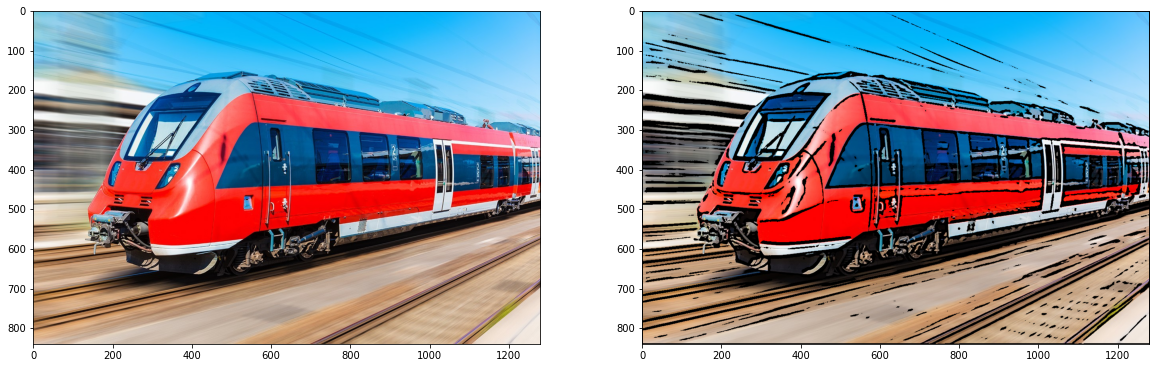

In [119]:
mask = adaptive_thresholding(gaussianFilter(image_g,3.5,5),17,6)
part1 = part1.astype(np.uint8)
mask = mask.astype(np.uint8)

masks = np.zeros(np.shape(image))
masks[:,:,0] = mask
masks[:,:,1] = mask
masks[:,:,2] = mask
masks = masks.astype(np.uint8)
output = np.bitwise_and(part1,masks)
plt.figure(figsize=(20,16))
plt.subplot(121)
plt.imshow(image)
plt.subplot(122)
plt.imshow(output)
plt.show()

# Q4. Dwight For Promotion

## a)

In [120]:
def dft_2d(image):
    img = image.copy()
    Mi,Ni = np.shape(img)
    m = np.arange(Mi)
    n = np.arange(Ni)
    output = np.zeros(np.shape(img),dtype=complex)
    for (m,n),out in np.ndenumerate(output):
        for (i,j),val in np.ndenumerate(img):
            output[m,n] = output[m,n] + val*np.exp(-2*math.pi*1j*((m*i/Mi) + (n*j/Ni)))

    return output

image= cv2.imread('../imgs/patt.jpg',0)
image = image[:64,:64]

out = dft_2d(image)

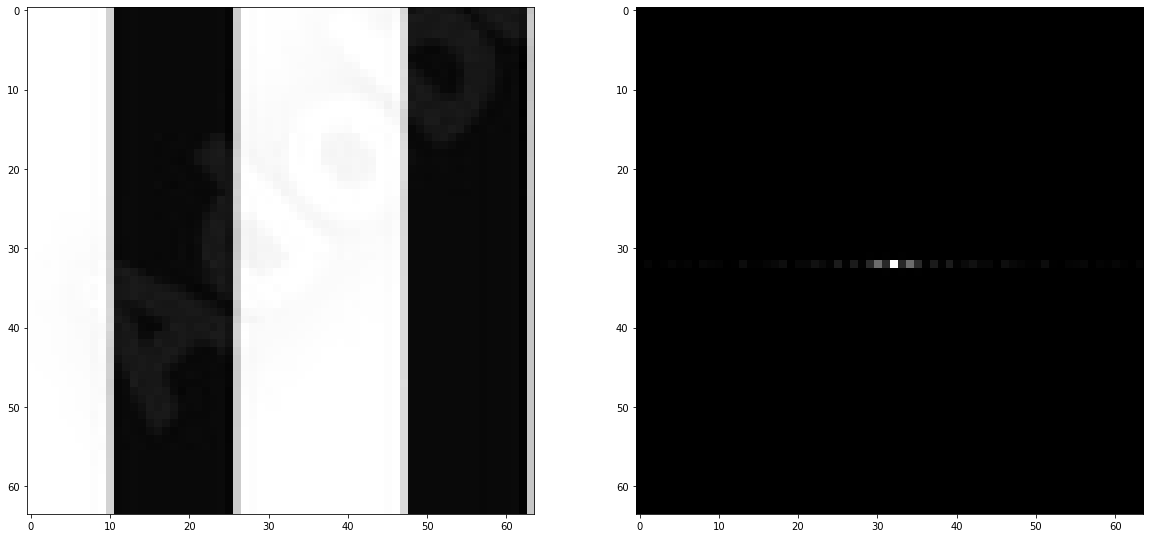

In [121]:
plt.figure(figsize=(20,40))
plt.subplot(121)
plt.imshow(image,cmap='gray')
plt.subplot(122)
plt.imshow((abs(np.fft.fftshift(out))),cmap='gray')

## b)

In [122]:
def fft_1d(n,seq):
    if(n==1): return seq
    fft_evn = fft_1d(int(n/2),seq[::2])
    fft_odd = fft_1d(int(n/2),seq[1::2])
    y = np.zeros(int(n),dtype=np.complex64)
    for k in range(int(n/2)):
        w = cmath.exp(-2*math.pi*1j*k/n)
        y[k] = fft_evn[k] + w*fft_odd[k]
        y[int(n/2)+k] = fft_evn[k] - w*fft_odd[k]
    return y

''' Testing '''
x = [1,2,3,4,5,6,7,8]
np_fft = np.fft.fft(x,8)
fft = fft_1d(8,x)
print(np_fft)
print(fft)

[36.+0.j    -4.+9.657j -4.+4.j    -4.+1.657j -4.+0.j    -4.-1.657j
 -4.-4.j    -4.-9.657j]
[36.+0.j    -4.+9.657j -4.+4.j    -4.+1.657j -4.+0.j    -4.-1.657j
 -4.-4.j    -4.-9.657j]


In [123]:
def fft_2d(array):

    matrix = array.copy()
    Mi,Ni = np.shape(matrix)
    matrix = matrix.astype(np.complex64)
    for i in range(Mi):
        matrix[i,:] = fft_1d(Ni,matrix[i,:])
    
    for i in range(Ni):
        matrix[:,i] = fft_1d(Mi,matrix[:,i])
    return matrix

'''Testing'''

x = np.array([[1,2,3,4],[1,2,3,4],[1,2,3,4],[1,2,3,4]],dtype=complex)
np_fft = np.fft.fft2(x,(4,4))
fft = fft_2d(x)
print('Inbuilt Function\n',np_fft)
print('\nImplemented Function\n',fft)

Inbuilt Function
 [[40.+0.j -8.+8.j -8.+0.j -8.-8.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]]

Implemented Function
 [[40.+0.j -8.+8.j -8.+0.j -8.-8.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]]


## c)

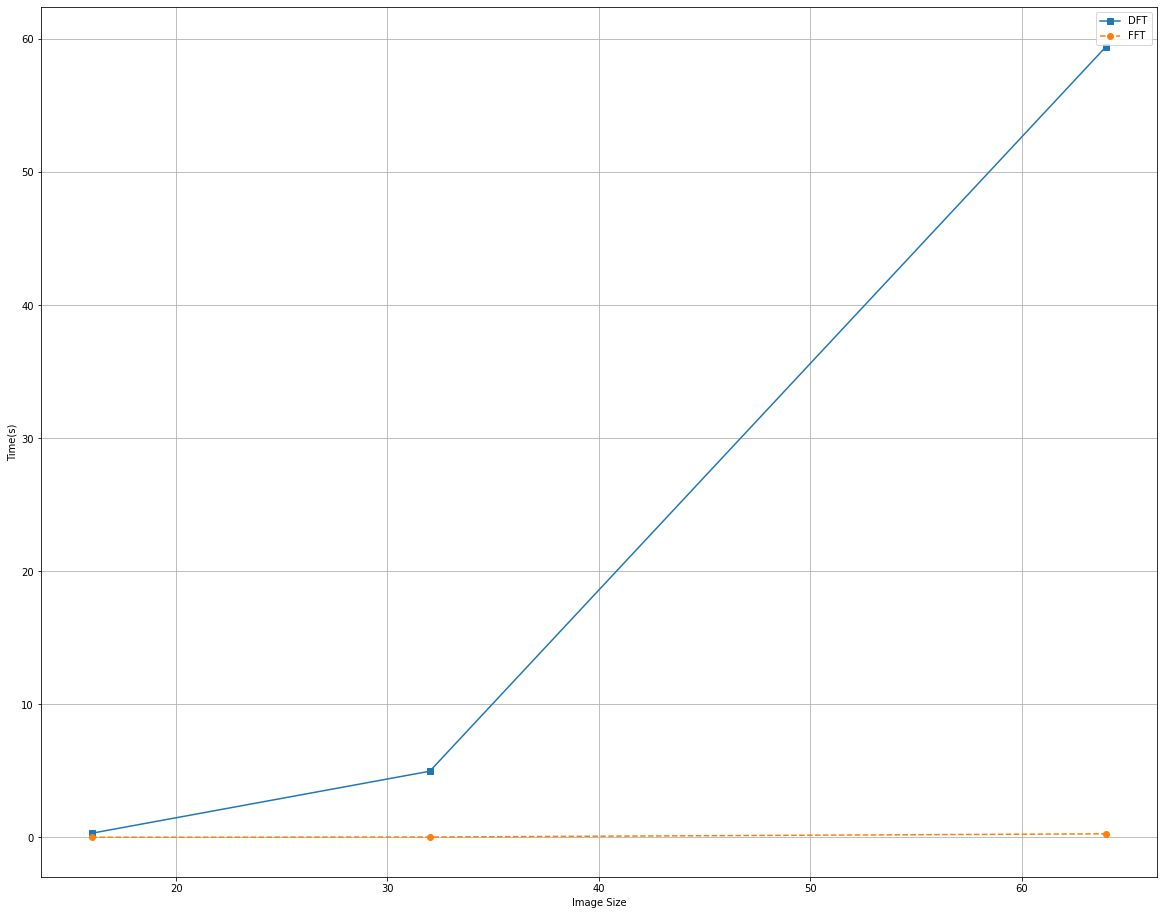

In [124]:
image = cv2.imread('../imgs/patt.jpg',0)
image_size = [16,32,64]
exec_time = []
exec_time_eff = []
for size in image_size:
    st_time = time.time()
    output = dft_2d(image[:size,:size])
    en_time = time.time()
    exec_time.append(en_time-st_time)

    st_time_eff = time.time()
    output_eff = fft_2d(image[:size,:size])
    en_time_eff = time.time()
    exec_time_eff.append(en_time_eff-st_time_eff)

plt.figure(figsize=(20,16))
plt.plot(image_size,exec_time,label=("DFT"),marker='s')
plt.plot(image_size,exec_time_eff,label=("FFT"),linestyle='dashed',marker='o')
plt.xlabel("Image Size")
plt.ylabel('Time(s)')
plt.legend()
plt.grid()
plt.show()

## d)

In [125]:
def ifft_1d(n,seq):
    if(n==1): return seq
    fft_evn = ifft_1d(int(n/2),seq[::2])
    fft_odd = ifft_1d(int(n/2),seq[1::2])
    y = np.zeros(int(n),dtype=np.complex64)
    for k in range(int(n/2)):
        w = cmath.exp(2*math.pi*1j*k/n)
        y[k] = fft_evn[k] + w*fft_odd[k]
        y[int(n/2)+k] = fft_evn[k] - w*fft_odd[k]
    return y

def ifft_2d(array):
    matrix = array.copy()
    matrix = matrix.astype(np.complex64)
    Mi,Ni = np.shape(matrix)
    for i in range(Mi):
        matrix[i,:] = ifft_1d(Ni,matrix[i,:])
    
    for i in range(Ni):
        matrix[:,i] = ifft_1d(Mi,matrix[:,i])
    return matrix/(Mi*Ni)

ifftxy = np.fft.ifft2(fft,(4,4))
xy = ifft_2d(fft)

print("Using Inbuilt Function\n",np.real(ifftxy))

print("Using Implemented Function\n",np.real(xy))


Using Inbuilt Function
 [[1. 2. 3. 4.]
 [1. 2. 3. 4.]
 [1. 2. 3. 4.]
 [1. 2. 3. 4.]]
Using Implemented Function
 [[1. 2. 3. 4.]
 [1. 2. 3. 4.]
 [1. 2. 3. 4.]
 [1. 2. 3. 4.]]


## e)

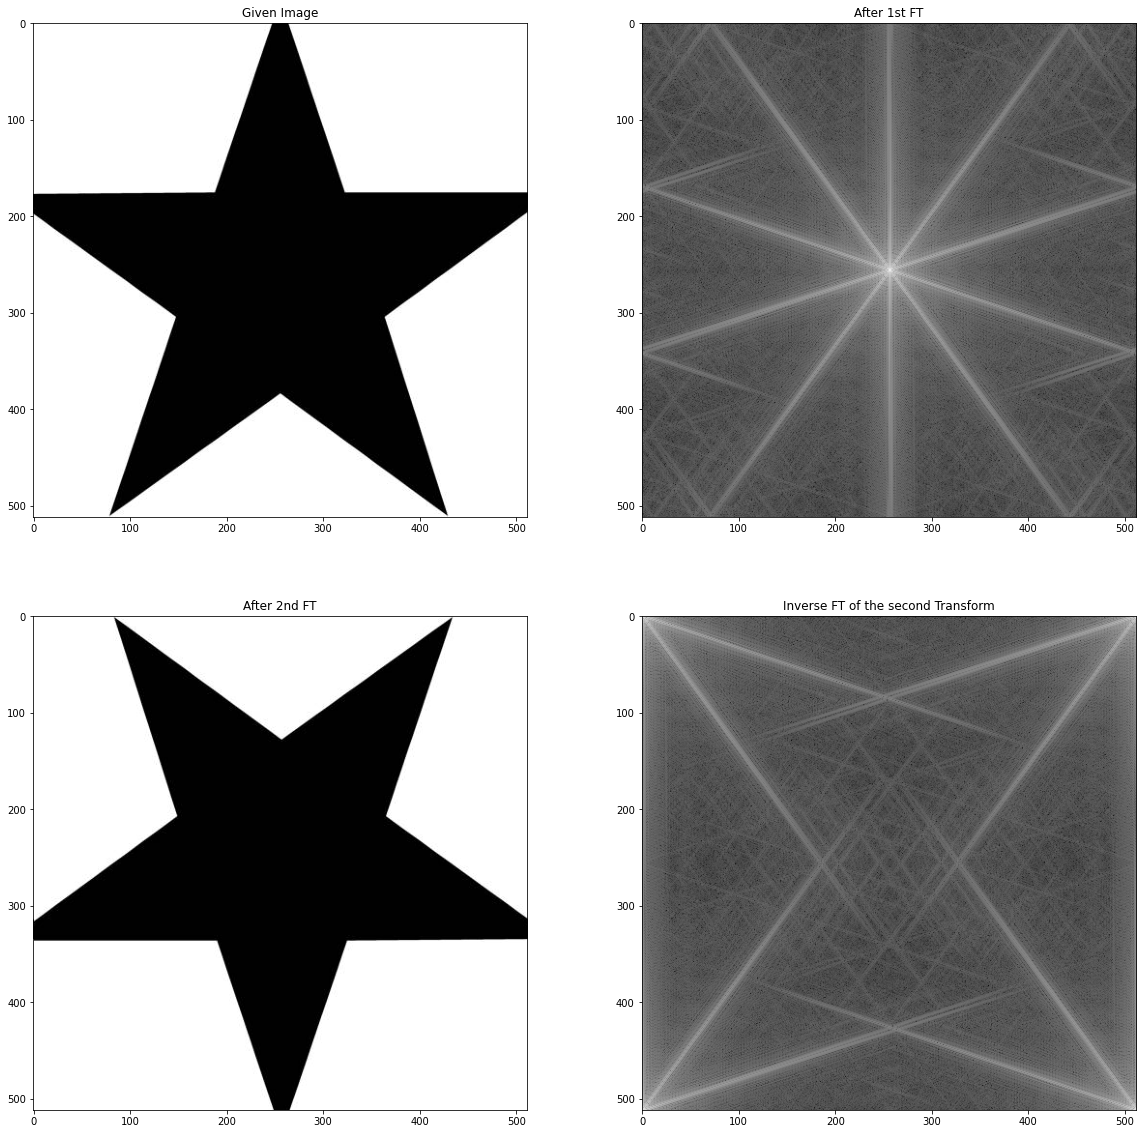

In [126]:
pattern = cv2.imread('../imgs/star.jpg',0)
pattern = pattern[50:612-50,50:612-50]

fft1 = fft_2d(pattern)
fft2 = fft_2d(fft1)
ifft = ifft_2d(fft2)

plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(pattern,cmap='gray')
plt.title("Given Image")
plt.subplot(222)
plt.imshow(np.log(np.abs(np.fft.fftshift(fft1))),cmap='gray')
plt.title("After 1st FT")
plt.subplot(223)
plt.imshow((np.abs((fft2))),cmap='gray')
plt.title("After 2nd FT")
plt.subplot(224)
plt.imshow(np.log(np.abs(ifft)),cmap='gray')
plt.title("Inverse FT of the second Transform")
plt.show()


Here we can observe that after second **FFT** we get the input image but it is flipped in both the directions. Here becaue the image is symmetrix along the x-axis we can't distinguish it but it is clear along the y-axis.




# Q5. Focused Dwight

## a)

In [127]:
def apply_filter(image,kernel):
    img = image.copy()
    ker = kernel.copy()
    output = np.zeros(np.shape(img),dtype=np.complex64)
    for (i,j),val in np.ndenumerate(img):
        output[i,j] = (img[i,j]*ker[i,j])
    
    return output


In [128]:
def ideal_lpf(D,M,N):
    filter = np.zeros((M,N))
    for (i,j),val in np.ndenumerate(filter):
        if((math.sqrt(math.pow((i-M/2),2)+ math.pow((j-N/2),2))) <= D): filter[i,j] =  1
    return filter


In [129]:
test = cv2.imread('../imgs/test.jpg',0)
test = np.pad(test,6,mode='symmetric')
# x,y = np.shape(test)
# print(x,y)
test = np.array(test)
test_fft = fft_2d(test)
kernel = ideal_lpf(30,512,512)
blur_fft = apply_filter(np.fft.fftshift(test_fft),kernel)
blur = ifft_2d(np.fft.ifftshift(blur_fft))

kernel15 = ideal_lpf(15,512,512)
blur_fft = apply_filter(np.fft.fftshift(test_fft),kernel15)
blur15 = ifft_2d(np.fft.ifftshift(blur_fft))

kernel50 = ideal_lpf(50,512,512)
blur_fft = apply_filter(np.fft.fftshift(test_fft),kernel50)
blur50 = ifft_2d(np.fft.ifftshift(blur_fft))



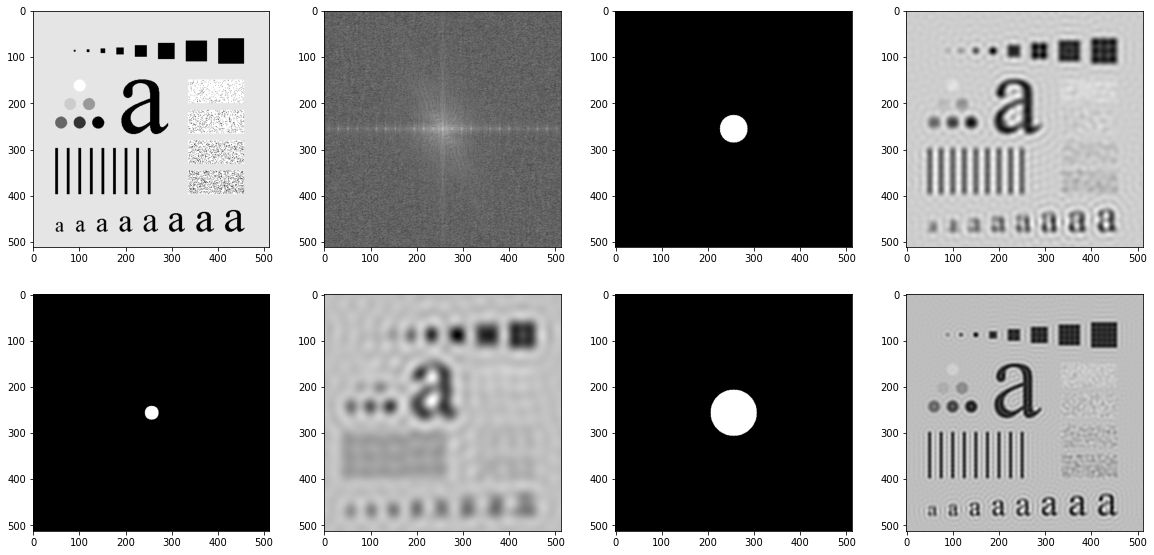

In [130]:
plt.figure(figsize=(20,20))
plt.subplot(441)
plt.imshow(test,cmap='gray',vmin=0,vmax=255)
plt.subplot(442)
plt.imshow(np.log2(np.abs(np.fft.fftshift(test_fft))),cmap='gray')
plt.subplot(443)
plt.imshow(np.abs(kernel),cmap='gray')
plt.subplot(444)
plt.imshow(blur.real,cmap='gray')
plt.subplot(445)
plt.imshow(np.abs(kernel15),cmap='gray',)
plt.subplot(446)
plt.imshow(blur15.real,cmap='gray')
plt.subplot(447)
plt.imshow(np.abs(kernel50),cmap='gray')
plt.subplot(448)
plt.imshow(blur50.real,cmap='gray')
plt.show()

**Ideal LPF**  
Here we first take FFT of the given image. Then we have a low pass filter that is we we have a filter where we only take lower frequencies here our filter is binay if the frequency is greater than a fixed value **D** we discard it other wise kp the frequencies. We multipe this kernel with the FFT of the image. Now we have the filter output but it is in frequemcy domain, so we take a IFFT of the output to get the result in spatial domain.

Here we can have difference values for **D**, as we increase D we get our ogrigional image back as we are considering more and more frequencies of the image and if **D** is small we remove most of the frequenies of the image hence it becomes blurr. 

## b)

In [131]:
def D(u,v,M,N):
    return (math.sqrt(math.pow((u-M/2),2)+ math.pow((v-N/2),2)))

def gaussian_kernel(D0,M,N):
    filter = np.zeros((M,N))
    for (i,j),val in np.ndenumerate(filter):
       filter[i,j] = math.exp(-1*math.pow(D(i,j,M,N)/D0,2)/(2))
    return filter

In [132]:
test = cv2.imread('../imgs/test.jpg',0)
test = np.pad(test,6,mode='symmetric')
# x,y = np.shape(test)
# print(x,y)
test = np.array(test)
test_fft = fft_2d(test)
kernel = gaussian_kernel(30,512,512)
blur_fft = apply_filter(np.fft.fftshift(test_fft),kernel)
blur = ifft_2d(np.fft.ifftshift(blur_fft))

kernel15 = gaussian_kernel(15,512,512)
blur_fft = apply_filter(np.fft.fftshift(test_fft),kernel15)
blur15 = ifft_2d(np.fft.ifftshift(blur_fft))

kernel50 = gaussian_kernel(50,512,512)
blur_fft = apply_filter(np.fft.fftshift(test_fft),kernel50)
blur50 = ifft_2d(np.fft.ifftshift(blur_fft))


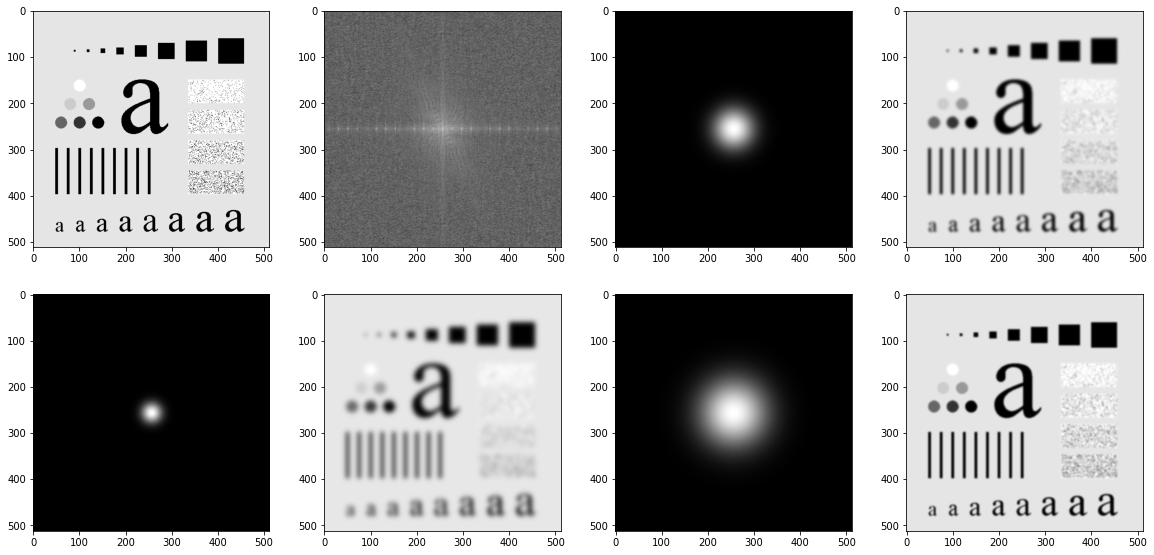

In [133]:
plt.figure(figsize=(20,20))
plt.subplot(441)
plt.imshow(test,cmap='gray',vmin=0,vmax=255)
plt.subplot(442)
plt.imshow(np.log2(np.abs(np.fft.fftshift(test_fft))),cmap='gray')
plt.subplot(443)
plt.imshow(np.abs(kernel),cmap='gray')
plt.subplot(444)
plt.imshow(blur.real,cmap='gray')
plt.subplot(445)
plt.imshow(np.abs(kernel15),cmap='gray',)
plt.subplot(446)
plt.imshow(blur15.real,cmap='gray')
plt.subplot(447)
plt.imshow(np.abs(kernel50),cmap='gray')
plt.subplot(448)
plt.imshow(blur50.real,cmap='gray')
plt.show()

**Gaussian lowpass**  
Unline the *Ideal LPF* here instead of hard threshold of the frequency we have a gaussian curve to select and weight the frequencies. Due to this smoothnes of the filter we don't get ridges in the output. Here also we have a cut-off frequency **D** but the threshold is a smooth gaussian curve. As we increase the **D** the blurriness of the image decreases.   

## c)
The key difference in *Gaussian lpf* and *Ideal lpf* is that in ideal case we have ridges in the output image but in gaussian image we dont have any ridges.    
Another is in ideal lpf the filter shape in spatial domain can be imagined as a solid cylinder but for a gaussian lpf its is more like a smooth pyramid.



# Q6. The Broken Scanner and Smart Jim

In [134]:
def colr_blur(image,kernel):
    img = image.copy()
    output= image.copy()
    fftr = np.fft.fft2(img[:,:,0])
    blurr = apply_filter(np.fft.fftshift(fftr),kernel)
    iblurr = np.fft.ifft2(np.fft.ifftshift(blurr))
    output[:,:,0] = iblurr.real

    fftg = np.fft.fft2(img[:,:,1])
    blurg = apply_filter(np.fft.fftshift(fftg),kernel)
    iblurg = np.fft.ifft2(np.fft.ifftshift(blurg))
    output[:,:,1] = iblurg.real

    fftb = np.fft.fft2(img[:,:,2])
    blurb = apply_filter(np.fft.fftshift(fftb),kernel)
    iblurb = np.fft.ifft2(np.fft.ifftshift(blurb))
    output[:,:,2] = iblurb.real

    return output

In [135]:
cart = cv2.imread('../imgs/cart.jpg')
cart = cv2.cvtColor(cart,cv2.COLOR_BGR2RGB)
# a = np.zeros((512,512,3),dtype=np.uint8)  # we can use this padding to implement our radix-2 FFT but this will add thick black borders to
# a[77:358+77,75:75+361,:] = cart           # the image hence here we will us the inbuilt fft funtion to apply the desired filter.
# cart = a 
cart = np.array(cart)
(x,y,z) = np.shape(cart)

kernel_si = [15,25,30,35]
images = []
for s in kernel_si:
    kernel_g = gaussian_kernel(s,x,y)
    output_g = colr_blur(cart,kernel_g)
    images.append(output_g)


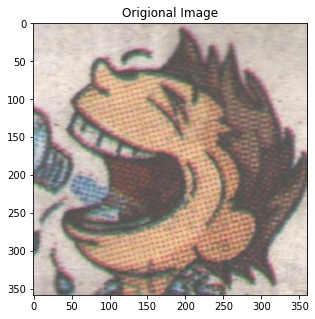

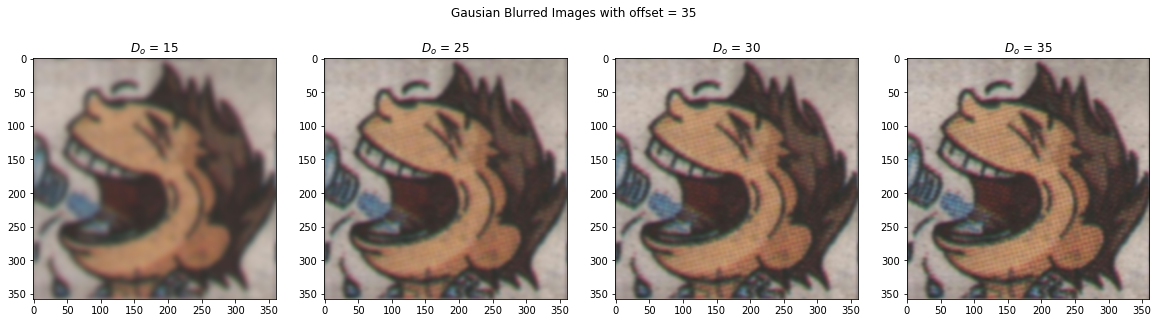

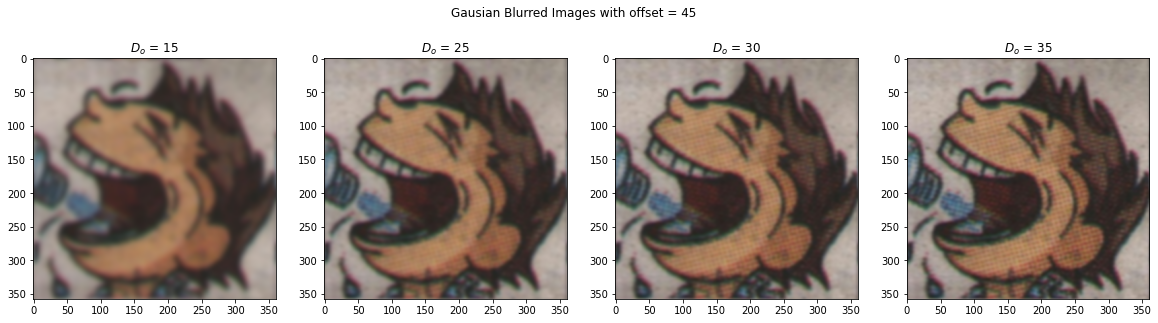

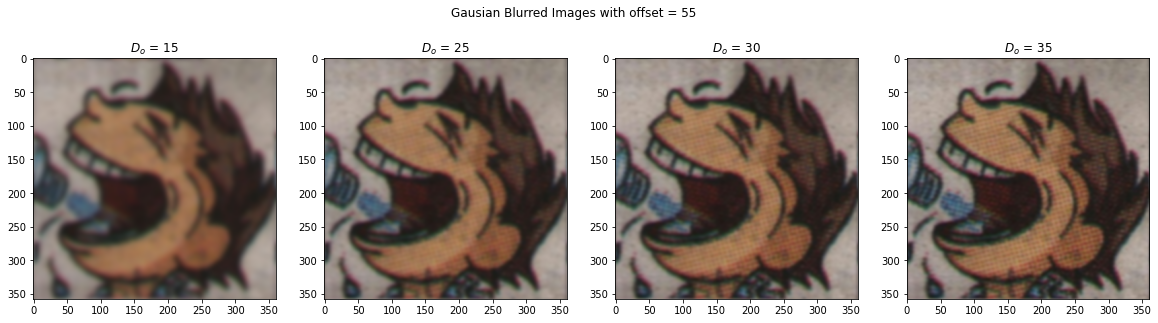

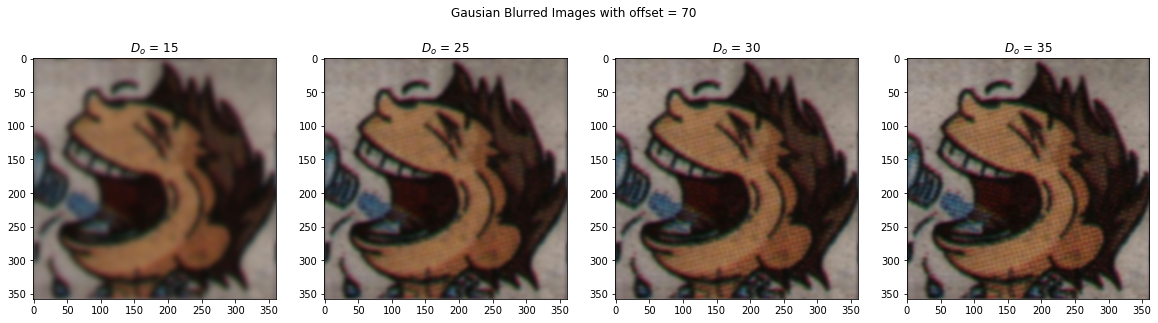

Text(0.5, 1.0, 'Gausian Blurred Images $D_o$ = 35 with offset = 70')

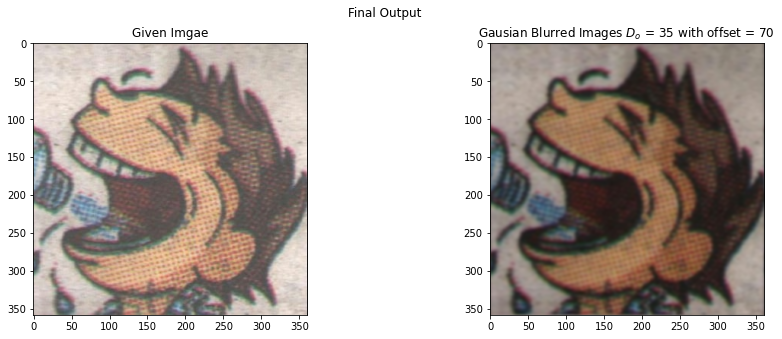

In [136]:

plt.figure(figsize=(5,5))
plt.imshow(cart)
plt.title("Origional Image")
plt.show()
ofset = [35,45,55,70]
for k in ofset:
    plt.figure(figsize=(20,5))
    plt.suptitle("Gausian Blurred Images with offset = "+str(k))
    for i in range(4):
        plt.subplot(1,4,i+1)    
        plt.imshow(images[i]-k)
        plt.title("$D_o$ = "+str(kernel_si[i]))
    plt.show()

plt.figure(figsize=(15,5))
plt.suptitle("Final Output")
plt.subplot(121)
plt.imshow(cart)
plt.title("Given Imgae")

plt.subplot(122)
plt.imshow(images[3]-55)
plt.title("Gausian Blurred Images $D_o$ = 35 with offset = "+str(k))


For this first we will pass the image from a LPF to remove the dots and then correct the color can be correct by just subtaction of a constant from the image.